In [547]:
from datetime import datetime, timedelta
import json
import pandas as pd
import requests
import matplotlib.pyplot as plt

season = 2021
round = 19 # Brazil
drivers = ['max_verstappen', 'hamilton', 'bottas']

In [548]:
# fetch data

try:
    response = requests.get(
        url="https://ergast.com/api/f1/%d/%d/laps.json" % (season, round),
        params={
            "limit": "10000",
        },
    )
    print('Response HTTP Status Code: {status_code}'.format(
        status_code=response.status_code))

    lapTimesAll = json.loads(response.content)
except requests.exceptions.RequestException:
    print('HTTP Request failed')

try:
    response = requests.get(
        url="https://ergast.com/api/f1/%d/%d/pitstops.json" % (season, round),
        params={
            "limit": "10000",
        },
    )
    print('Response HTTP Status Code: {status_code}'.format(
        status_code=response.status_code))

    pitStopsAll = json.loads(response.content)
except requests.exceptions.RequestException:
    print('HTTP Request failed')

Response HTTP Status Code: 200
Response HTTP Status Code: 200


In [549]:
# create table from raw data

lapTimesData = lapTimesAll['MRData']['RaceTable']['Races'][0]['Laps']

lapTimes = {
    'lap': [],
    'driver': [],
    'time': [],
    'position': []
}

for i in range(len(lapTimesData)):
    lap = lapTimesData[i]

    timings = lap['Timings']

    for j in range(len(timings)):
        timing = timings[j]

        lapTime = datetime.strptime(timing['time'], '%M:%S.%f')
        delta = timedelta(minutes=lapTime.minute, seconds=lapTime.second, microseconds=lapTime.microsecond)

        lapTimes['lap'].append(int(lap['number']))
        lapTimes['driver'].append(timing['driverId'])
        lapTimes['time'].append(delta)
        lapTimes['position'].append(int(timing['position']))

lapTimesDF = pd.DataFrame(lapTimes)
lapTimesDF.head()

,lap,driver,time,position
0,1,max_verstappen,0 days 00:01:18.399000,1
1,1,perez,0 days 00:01:19.651000,2
2,1,bottas,0 days 00:01:20.541000,3
3,1,leclerc,0 days 00:01:21.519000,4
4,1,sainz,0 days 00:01:22.506000,5


In [550]:
# create table from raw data

pitStopsData = pitStopsAll['MRData']['RaceTable']['Races'][0]['PitStops']

pitStops = {
    'lap': [],
    'driver': [],
    'time': [],
    'stop': [],
    'duration': []
}

for i in range(len(pitStopsData)):
    pitStop = pitStopsData[i]

    pitStops['lap'].append(int(pitStop['lap']))
    pitStops['driver'].append(pitStop['driverId'])
    pitStops['time'].append(pitStop['time'])
    pitStops['stop'].append(int(pitStop['stop']))
    pitStops['duration'].append(pitStop['duration'])

pitStopsDF = pd.DataFrame(pitStops)
pitStopsDF.head()

,lap,driver,time,stop,duration
0,1,norris,14:04:50,1,27.313
1,4,tsunoda,14:08:22,1,31.939
2,6,russell,14:11:08,1,22.978
3,6,tsunoda,14:11:57,2,17.758
4,6,norris,14:12:08,2,17.719


In [551]:
lapTimesDFDrivers = {}

for driver in drivers:
    lapTimesDFDriver = lapTimesDF[lapTimesDF.driver.eq(driver)].sort_values('lap').reset_index(drop=True)
    lapTimesDFDrivers[driver] = lapTimesDFDriver

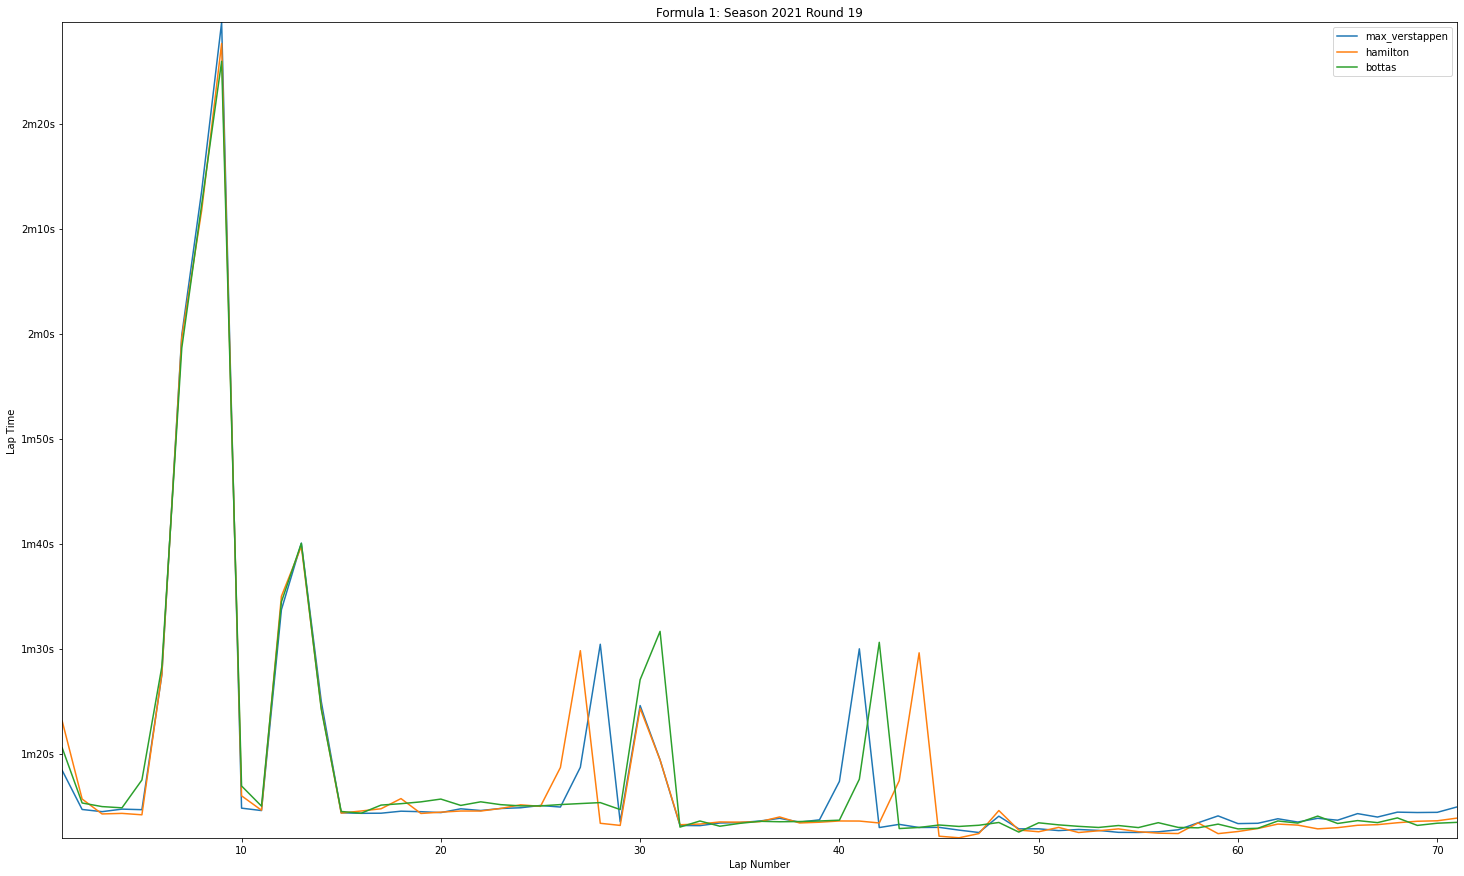

In [552]:
# plot

fig, ax = plt.subplots()
fig.set_size_inches(25, 15, forward=True)

ax.margins(x=0, y=0)
ax.set_title('Formula 1: Season %d Round %d' % (season, round))
ax.set_ylabel('Lap Time')
ax.set_xlabel('Lap Number')

def duration_fmt(x, pos):
    seconds = x / 10**9
    minutes = (seconds // 60)
    secondsLeft = seconds - (minutes*60)

    return '%dm%ds' % (minutes, secondsLeft)

ax.yaxis.set_major_formatter(duration_fmt)

for driver in lapTimesDFDrivers:
    ax.plot(lapTimesDFDrivers[driver].lap, lapTimesDFDrivers[driver].time, label=driver)

ax.legend()
plt.show()

In [553]:
# stack timing

stackedLapTimesDFDrivers = {}

for driver in lapTimesDFDrivers:
    stackedLapTimesDFDrivers[driver] = lapTimesDFDrivers[driver].assign(time=lapTimesDFDrivers[driver].time.cumsum())

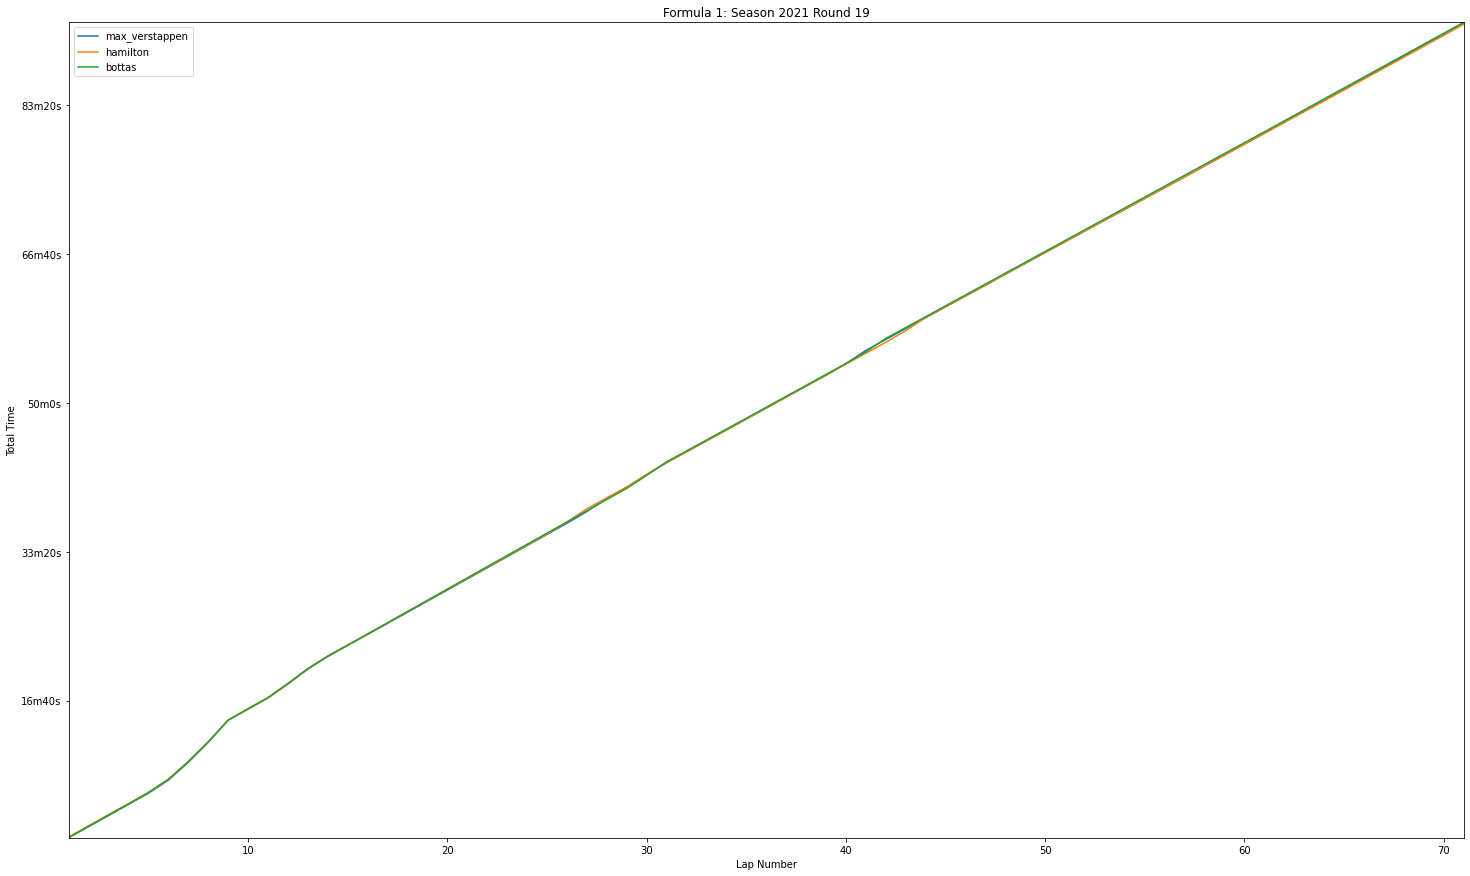

In [554]:
# plot

fig, ax = plt.subplots()
fig.set_size_inches(25, 15, forward=True)

ax.margins(x=0, y=0)
ax.set_title('Formula 1: Season %d Round %d' % (season, round))
ax.set_ylabel('Total Time')
ax.set_xlabel('Lap Number')

def duration_fmt(x, pos):
    seconds = x / 10**9
    minutes = (seconds // 60)
    secondsLeft = seconds - (minutes*60)

    return '%dm%ds' % (minutes, secondsLeft)

ax.yaxis.set_major_formatter(duration_fmt)

for driver in stackedLapTimesDFDrivers:
    df = stackedLapTimesDFDrivers[driver]

    ax.plot(df.lap, df.time, label=driver)

ax.legend()
plt.show()

In [555]:
# versus timing

versusData = []

versusADriver = 'max_verstappen'
versusA = stackedLapTimesDFDrivers[versusADriver]
versusBDriver = 'hamilton'
versusB = stackedLapTimesDFDrivers[versusBDriver]

for index, rowA in versusA.iterrows():
    rowB = versusB.loc[versusB['lap'] == rowA.lap].iloc[0]

    versusData.append([rowA.lap, '%s <> %s' % (rowA.driver, rowB.driver), rowA.time - rowB.time])

versusDF = pd.DataFrame(versusData, columns=['lap', 'driver', 'time'])
versusDF = versusDF.assign(time=lambda x: x['time'].dt.total_seconds())

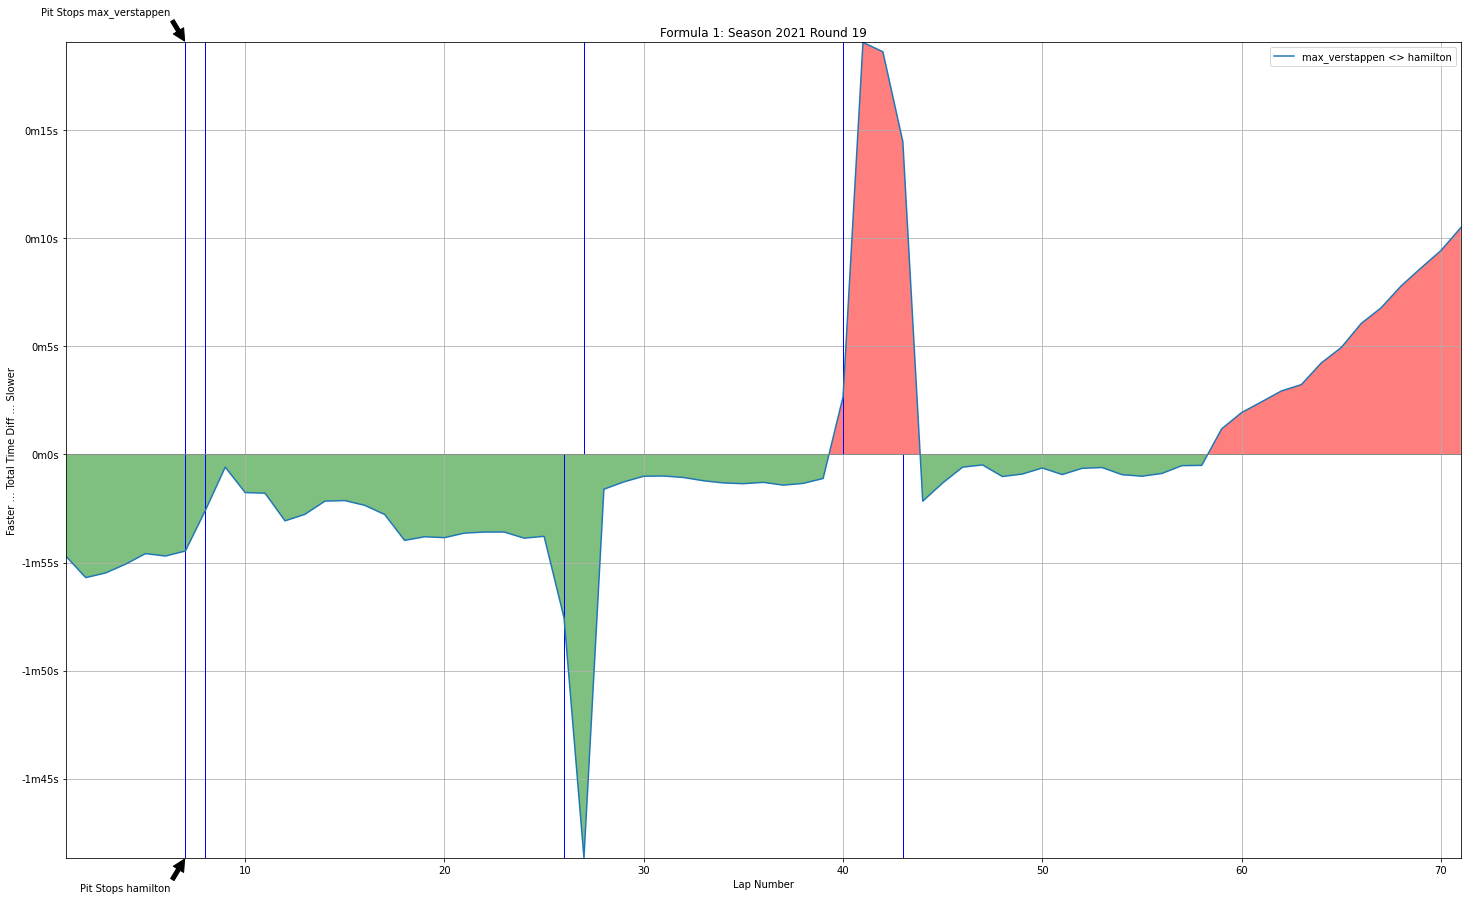

In [556]:
# plot

fig, ax = plt.subplots()
fig.set_size_inches(25, 15, forward=True)

ax.margins(x=0, y=0)
ax.set_title('Formula 1: Season %d Round %d' % (season, round))
ax.set_ylabel('Faster … Total Time Diff … Slower')
ax.set_xlabel('Lap Number')

def duration_s_fmt(seconds, pos):
    minutes = (seconds // 60)
    secondsLeft = seconds - (minutes*60)

    return '%dm%ds' % (minutes, secondsLeft)

ax.yaxis.set_major_formatter(duration_s_fmt)

ax.plot(versusDF.lap, versusDF.time, label=versusDF.iloc[0].driver)
ax.axhline(0, color='grey', linewidth=0.8)

ax.fill_between(versusDF.lap, 0, versusDF.time, where=versusDF.time > 0, facecolor='red', alpha=0.5, interpolate=True)
ax.fill_between(versusDF.lap, 0, versusDF.time, where=versusDF.time < 0, facecolor='green', alpha=0.5, interpolate=True)
ax.grid(True)

max = versusDF['time'].max()
if max <= 0:
    max = 1
first = True
for index, row in pitStopsDF[pitStopsDF['driver'] == versusADriver].iterrows():
    if first:
        ax.annotate('Pit Stops %s' % versusADriver,
                    xy=(row['lap'], max), xycoords='data',
                    xytext=(-15, 25), textcoords='offset points',
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='right', verticalalignment='bottom')
        first = False

    ax.vlines(row['lap'], 0, max,  color='blue', linewidth=1)

min = versusDF['time'].min()
if min >= 0:
    min = -1
first = True
for index, row in pitStopsDF[pitStopsDF['driver'] == versusBDriver].iterrows():
    if first:
        ax.annotate('Pit Stops %s' % versusBDriver,
                    xy=(row['lap'], min), xycoords='data',
                    xytext=(-15, -25), textcoords='offset points',
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='right', verticalalignment='top')
        first = False

    ax.vlines(row['lap'], 0, min,  color='blue', linewidth=1)

ax.legend()
plt.show()